In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

# reflect the tables

Base = automap_base()

Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.

from sqlalchemy import inspect, func
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for x in columns:
    print(x['name'], x["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
measurement_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent_date = list(np.ravel(measurement_date))[0]
recent_date



'2017-08-23'

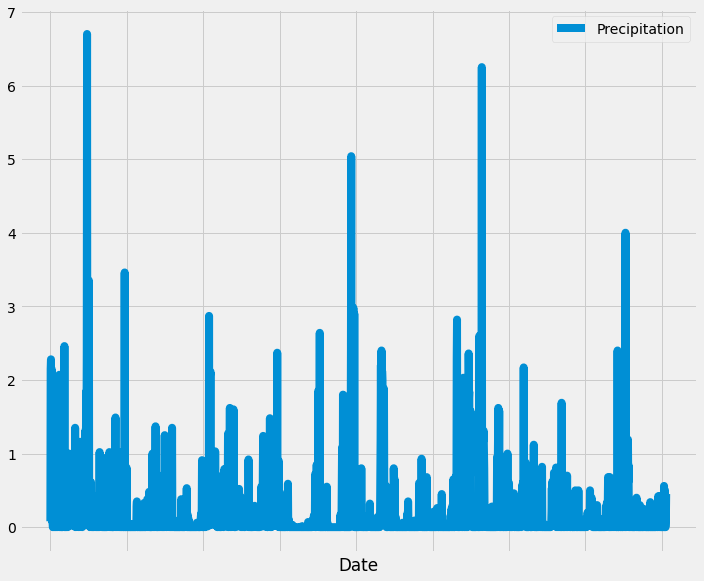

<Figure size 432x288 with 0 Axes>

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
format_recent_date = dt.datetime.strptime(recent_date,"%Y-%m-%d")
full_year = format_recent_date - dt.timedelta(days=365)



# Perform a query to retrieve the data and precipitation scores
year_results = session.query(measurement.date, measurement.prcp).order_by(measurement.date.asc()).filter(measurement.date >= full_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
year_results_df = pd.DataFrame(year_results)
year_results_df.columns = ['Date', 'Precipitation']

# Sort the dataframe by date
year_results_df.sort_values(by=['Date'], ascending=True)
year_results_df = year_results_df.dropna()
year_results_df = year_results_df.reset_index(drop=True)
year_results_df
# Use Pandas Plotting with Matplotlib to plot the data
precplot=year_results_df.plot(figsize=(10,8),legend=True, linewidth=8.0, grid=True)

plt.setp(precplot.get_xticklabels(), visible=False)
plt.tight_layout()
plt.xlabel("Date")
plt.show()
plt.savefig("Images/precipitation.png")


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_results_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
inspector = inspect(engine)
columns = inspector.get_columns('station')
for x in columns:
    print(x['name'], x["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
count_station=session.query(func.count(station.id)).all()
count_station

[(9,)]

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_results = session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
station_results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperatures = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station==station_results[0][0]).all()
temperatures

[(54.0, 85.0, 71.66378066378067)]

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_date = session.query(measurement.date).order_by(measurement.date.desc()).filter(measurement.station==station_results[0][0]).first()
recent_temp_date = list(np.ravel(temperature_date))[0]
format_temp_date = dt.datetime.strptime(recent_temp_date,"%Y-%m-%d")

one_year = format_temp_date-dt.timedelta(days=365)

temperature_data = session.query(measurement.tobs).filter(measurement.station==station_results[0][0]).filter(measurement.date>=one_year).all()
temperature_df = pd.DataFrame(temperature_data)
temperature_df.columns = ['Tobs']
temperature_df


,Tobs
0,79.0
1,81.0
2,79.0
3,78.0
4,77.0
...,...
351,77.0
352,77.0
353,76.0
354,76.0


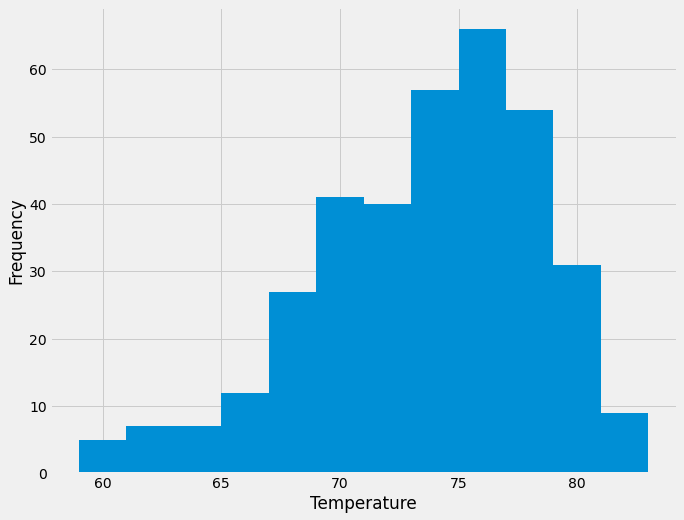

<Figure size 432x288 with 0 Axes>

In [18]:
# plotting histogram
hist = temperature_df['Tobs'].hist(bins=12, figsize=(10,8))
hist.set_ylabel("Frequency")
hist.set_xlabel("Temperature")
plt.show()
plt.savefig("Images/Histogram.png")

# Close session

In [19]:
# Close Session
session.close()